# Train Model with GPT architecture Using Pre-setting Vocab and Contrastive Learning

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
import torch.backends.cudnn as cudnn

# import custom modules
from datasets.data_loader import *
from models.GPT import *
from models.loss import InfoNCELoss
from models.trfm import *
from utils.utils import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
train_ce_loss_history = []
test_ce_loss_history = []
train_info_loss_history = []
test_info_loss_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data from the file
train_data = pd.read_csv('./data/train_contrastive_dataset.csv')
test_data = pd.read_csv('./data/test_contrastive_dataset.csv')

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
epoch = 10
InfoNCEloss_weight = 0.1

In [7]:
# create the dataset and dataloader
# train_dataset = Contrastive_Seq2seqDataset(train_data, vocab, MAX_LEN)
# test_dataset = Contrastive_Seq2seqDataset(test_data, vocab, MAX_LEN)
train_dataset = Contrastive_Seq2seqDataset_random(train_data, vocab, MAX_LEN)
test_dataset = Contrastive_Seq2seqDataset_random(test_data, vocab, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# create the model
config = GPTConfig(vocab_size=charlen, block_size=220, num_props=24)
model = GPT(config).to(device)

# load model
trfm = TrfmSeq2seq(charlen, 256, charlen, 4).to(device)
trfm.load_state_dict(torch.load('./model_hub/trfm_new_2_10000.pkl'))
trfm.eval()

# set trfm gradient to false which won't be updated
for param in trfm.parameters():
    param.requires_grad = False

# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

100%|██████████| 14803/14803 [00:00<00:00, 52136.25it/s]


total parameters: 3.25M


In [8]:
# train function
def train(model, trfm, train_dataloader, loss_func, optim, device, weight=0.1):
    model.train()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    # tau = 1.0
    # min_tau = 0.1
    # decay_rate = 0.999
    for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        positive_smiles = positive_smiles.to(device)
        negative_smiles = negative_smiles.to(device)
        
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        logits = model(idx=tgt_input, prop=synthesis_condition)
        
        # Compute CrossEntropy Loss
        logits_reshaped = logits.view(-1, logits.size(-1))
        tgt_label_reshaped = tgt_label.view(-1)
        loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
        
        # calculate the accuracy
        pred = torch.argmax(logits, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # Gumbel-Softmax Sampling
        # logits: [batch_size, seq_len, vocab_size]
        # tau = max(min_tau, tau * decay_rate)
        samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
        # samples = F.gumbel_softmax(logits, tau, hard=True)
        samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
        # add the start token to the samples
        stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
        samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
        
        # Compute InfoNCE Loss
        loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.07)
        
        # combine the two loss
        loss = loss_ce + weight * loss_infonce
        
        # backward
        loss.backward()
        optim.step()
        
        # statistics
        total_loss += loss.item()
        total_loss_crossentropy += loss_ce.item()
        total_loss_infonce += loss_infonce.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num, total_loss_crossentropy / len(train_dataloader), total_loss_infonce / len(train_dataloader)

In [9]:
def evaluate(model, trfm, test_dataloader, loss_func, device, weight=0.1):
    model.eval()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            positive_smiles = positive_smiles.to(device)
            negative_smiles = negative_smiles.to(device)
            
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            
            # forward
            logits = model(idx=tgt_input, prop=synthesis_condition)
            
            # Compute CrossEntropy Loss
            logits_reshaped = logits.view(-1, logits.size(-1))
            tgt_label_reshaped = tgt_label.view(-1)
            loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
            
            # calculate the accuracy
            pred = torch.argmax(logits, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            
            # Gumbel-Softmax Sampling
            # logits: [batch_size, seq_len, vocab_size]
            samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
            samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
            # add the start token to the samples
            stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
            samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
            
            # Compute InfoNCE Loss
            loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.2)
            
            # combine the two loss
            loss = loss_ce + weight * loss_infonce
            
            # statistics
            total_loss += loss.item()
            total_loss_crossentropy += loss_ce.item()
            total_loss_infonce += loss_infonce.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num, total_loss_crossentropy / len(test_dataloader), total_loss_infonce / len(test_dataloader)

In [10]:
# # train the model
# for i in range(epoch):
#     train_loss, train_acc, train_ce, train_info = train(model, trfm, train_dataloader, loss_func, optim, device)
#     # train_loss, train_acc, train_ce, train_info = train(model, trfm, test_dataloader, loss_func, optim, device)
#     train_loss_history.append(train_loss)
#     train_acc_history.append(train_acc)
#     train_ce_loss_history.append(train_ce)
#     train_info_loss_history.append(train_info)
#     print('epoch: %d, train loss: %.4f, train acc: %.4f, train crossentropy loss: %.4f, train infonce loss: %.4f' % (i, train_loss, train_acc, train_ce, train_info))
#     test_loss, test_acc, test_ce, test_info = evaluate(model, trfm, test_dataloader, loss_func, device)
#     test_loss_history.append(test_loss)
#     test_acc_history.append(test_acc)
#     test_ce_loss_history.append(test_ce)
#     test_info_loss_history.append(test_info)
#     print('epoch: %d test loss: %.4f, test acc: %.4f, test crossentropy loss: %.4f, test infonce loss: %.4f' % (i, test_loss, test_acc, test_ce, test_info))
#     if i == 0:
#         best_acc = test_acc
#     if test_acc > best_acc:
#         best_acc = test_acc
#         torch.save(model.state_dict(), save_best_weight_path + 'best_GPT_contrastive_model.pth')
#     torch.save(model.state_dict(), save_best_weight_path + 'last_GPT_contrastive_model.pth')

In [11]:
# load the model
model = GPT(config).to(device)
model.load_state_dict(torch.load('./checkpoints/best_GPT_contrastive_model.pth'))

<All keys matched successfully>

In [17]:
def generate_gpt(model, start_sequence, condition_props, max_length, vocab, device, temperature=0.5, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (GPT): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device

    for _ in range(max_length - start_sequence.size(1)):
        # Get the current sequence length
        current_length = generated_sequences.size(1)

        # Forward pass through the model
        logits = model(generated_sequences, condition_props)  # (batch_size, seq_length, vocab_size)

        # Extract the logits for the last time step
        next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
            mask = torch.full_like(next_token_logits, float('-inf'))
            mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
            next_token_logits = mask

        # Convert logits to probabilities
        next_token_probs = F.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
        
        # Get the most likely next token
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        # Append the generated token to the sequence
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)

        # Check if all sequences have reached the end token
        if all(next_token[i].item() == EOS for i in range(batch_size)):
            break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS and idx.item() != UNK:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [18]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_gpt(model, tgt[:, :2], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 232/232 [01:27<00:00,  2.67it/s]


In [19]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

Validity rate: 1.0
Uniqueness rate: 0.7894736842105263
Novelty rate: 1.0
Reconstructability rate: 0.0
Novelty rate: 1.0
IntDiv: 0.5182318592698257


[14:05:54] SMILES Parse Error: syntax error while parsing: c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>
[14:05:54] SMILES Parse Error: Failed parsing SMILES 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>' for input: 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>'
[14:05:54] SMILES Parse Error: syntax error while parsing: c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>
[14:05:54] SMILES Parse Error: Failed parsing SMILES 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>' for input: 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>'
[14:05:54] SMILES Parse Error: syntax error while parsing: c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1
[14:05:54] SMILES Parse Error: Failed parsing SMILES 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1' for input: 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1'
[14:05:54] SMILES Parse Error: syntax error while parsing: C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1
[14:05:54] SMILES Parse Error: Failed parsing SMILES 'C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1' for input: 'C1C(

FCD score: 0.27741925459253025


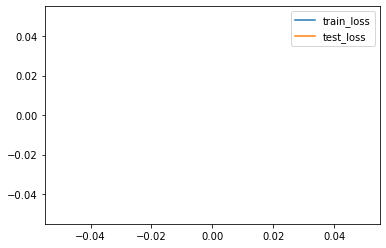

In [20]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'GPT_Contrastive_Loss')

In [21]:
# save the history to the csv file in log folder
history = pd.DataFrame({'train_loss': train_loss_history, 'train_acc': train_acc_history, 'test_loss': test_loss_history, 'test_acc': test_acc_history, 'train_ce_loss': train_ce_loss_history, 'test_ce_loss': test_ce_loss_history, 'train_info_loss': train_info_loss_history, 'test_info_loss': test_info_loss_history})
history.to_csv(log_dir + 'GPT_Contrastive_History.csv', index=False)